In [1]:
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms, io
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms as T
from torchvision.io import read_image, write_jpeg
from torch.nn import functional as F
import numpy as np
import json
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -qq /content/drive/MyDrive/data.zip

In [4]:
preprocessing = T.Compose(
    [
        T.ToPILImage(),
        T.Resize((250, 500)), 
        T.ToTensor()
    ]
)

class CustomImageDataset(Dataset):
    def __init__(self, noise_dir, clean_dir, aug=None):
        self.noise_dir = noise_dir
        self.clean_dir = clean_dir
        self.noise_names = sorted(os.listdir(noise_dir))
        self.clean_names = sorted(os.listdir(clean_dir))
        self.aug = aug
    def __len__(self):
        return len(self.noise_names)
    
    def __getitem__(self, idx):
        noisy_img = read_image(os.path.join(self.noise_dir, self.noise_names[idx]))
        clean_img = read_image(os.path.join(self.clean_dir, self.clean_names[idx]))
        if self.aug:
            noisy_img = self.aug(noisy_img)
            clean_img = self.aug(clean_img)
        return noisy_img, clean_img

In [5]:
ae_dataset = CustomImageDataset('train', 'train_cleaned', aug=preprocessing)

In [6]:
loader = DataLoader(ae_dataset, batch_size=16)

In [7]:
noisy_batch, clean_batch = next(iter(loader))

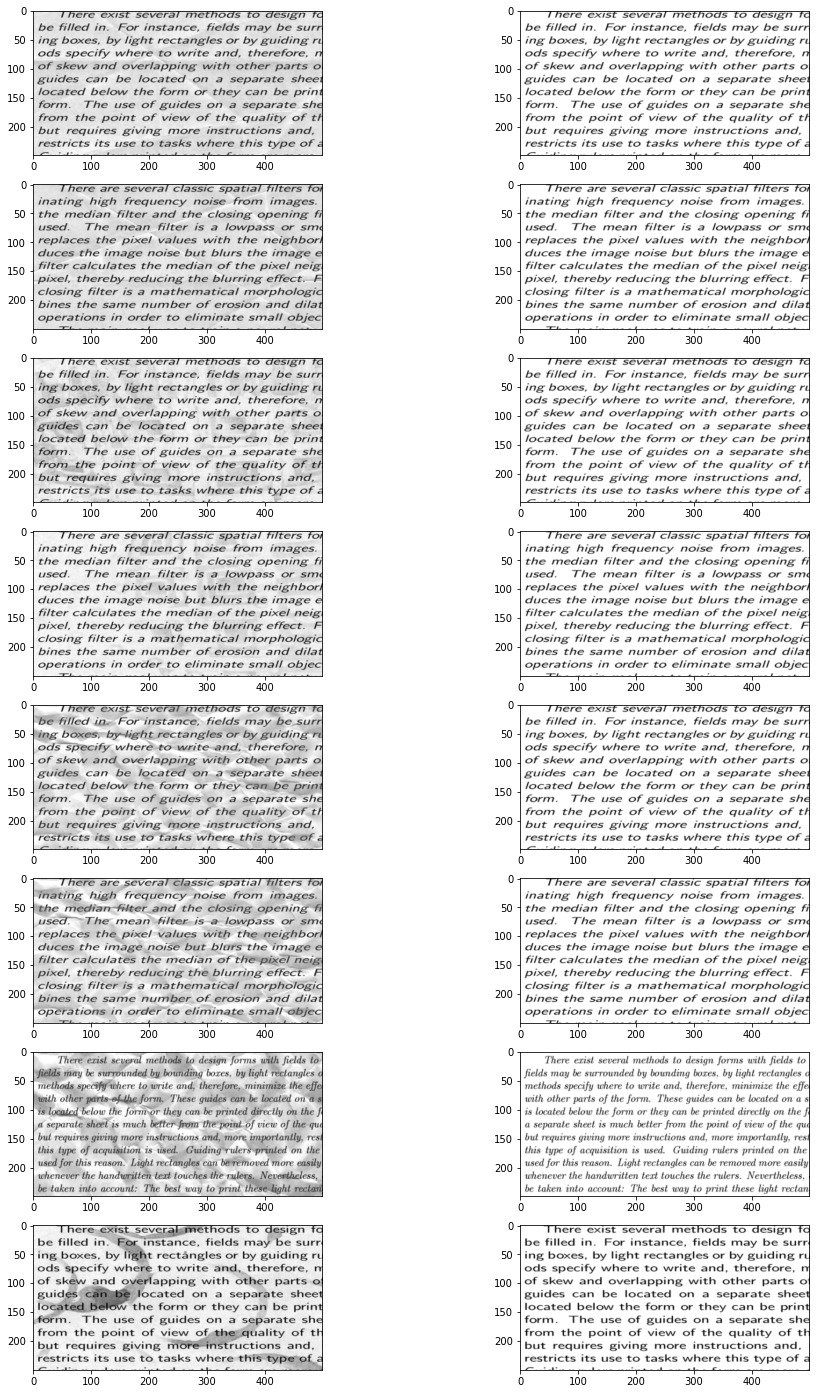

In [8]:
fig, ax = plt.subplots(8, 2, figsize=(16, 25))


for i in range(8):
    ax[i, 0].imshow(noisy_batch[i].squeeze(0), cmap='gray')
    ax[i, 1].imshow(clean_batch[i].squeeze(0), cmap='gray')


In [9]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=12, padding=10),
            nn.BatchNorm2d(64),
            nn.SELU()
        )

        self.layer_2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=4),
            nn.BatchNorm2d(32),
            nn.SELU()
        )

        self.layer_3 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=2),
            nn.BatchNorm2d(16),
            nn.SELU()
        )

        self.decoder_1 = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=2),
            nn.SELU()
        )

        self.decoder_2 = nn.Sequential(
            nn.ConvTranspose2d(32, 64, kernel_size=4),
            nn.SELU()
        )

        self.decoder_2_2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),
            nn.SELU()
        )

        self.decoder_3 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=12, padding=10),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)

        out = self.decoder_1(x)
        out = self.decoder_2_2(self.decoder_2(out))
        out = self.decoder_3(out)
        return out

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AE()

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.MSELoss(reduction='sum')

In [11]:
def train_ae(model, n_epochs, loss=None):
    model.to(device)
    if loss is None:
        train_loss = []
    else: train_loss = loss

    for i in range(n_epochs):
        model.train()
        running_loss = []
        for noisy, clean in loader:
            noisy = noisy.to(device)
            clean = clean.to(device)
            reconstructed = model(noisy)
            optimizer.zero_grad()
            loss = criterion(reconstructed, clean)
            loss.backward()
            optimizer.step()
            running_loss.append(loss.item())
        train_loss.append(np.mean(running_loss))
        
        noisy_sample = noisy[0]
        clean_sample = clean[0]

        
        if i % 5 == 0.:
            fig, ax = plt.subplots(1, 3, figsize=(16, 8))

            ax[0].imshow(noisy_sample.detach().cpu().numpy()[0], cmap='gray')
            ax[1].imshow(reconstructed.detach().cpu().numpy()[0][0], cmap='gray')
            ax[2].imshow(clean_sample.detach().cpu().numpy()[0], cmap='gray')
            plt.show()
            print(f'Epoch {i}, model saving...')
            torch.save(model.state_dict(), f'drive/MyDrive/{i}-epoch.pt')
    return train_loss


In [13]:
model.load_state_dict(torch.load('/content/drive/MyDrive/45-epoch.pt'))


<All keys matched successfully>

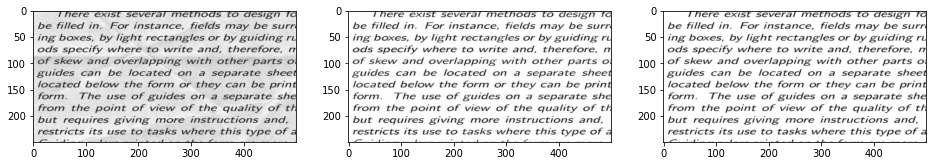

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
ax[0].imshow(ae_dataset[0][0][0].detach().cpu().numpy(), cmap='gray')
ax[1].imshow(model(torch.unsqueeze(ae_dataset[0][0], 0)).detach().cpu().numpy()[0][0], cmap='gray')
ax[2].imshow(ae_dataset[0][1].detach().cpu().numpy()[0], cmap='gray')